In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

trained_bold = nib.load('./norm_unnorm_armotor_result.nii').get_fdata()
raw_bold = nib.load('./armotor_2894.nii').get_fdata()
eps = 1e-8

for i in range(trained_bold.shape[0]):
    for j in range(trained_bold.shape[1]):
        for k in range(trained_bold.shape[2]):
            mean = np.mean(trained_bold[i,j,k, :])
            std_dev = np.std(trained_bold[i,j,k, :]) + eps
            trained_bold[i,j,k,:] = (trained_bold[i,j,k,:] - mean) / std_dev


for i in range(raw_bold.shape[0]):
    for j in range(raw_bold.shape[1]):
        for k in range(raw_bold.shape[2]):
            mean = np.mean(raw_bold[i,j,k, :])
            std_dev = np.std(raw_bold[i,j,k, :]) + eps
            raw_bold[i,j,k,:] = (raw_bold[i,j,k,:] - mean) / std_dev



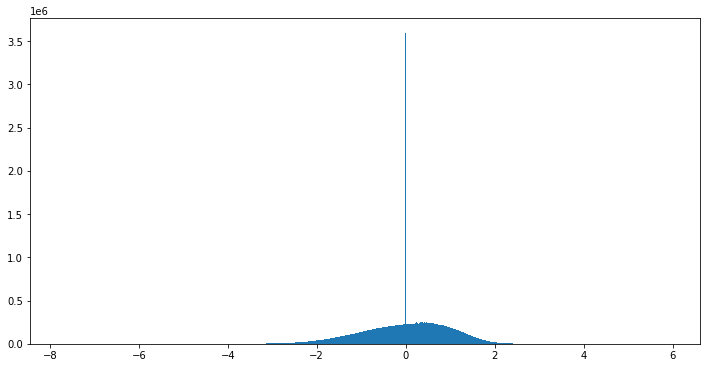

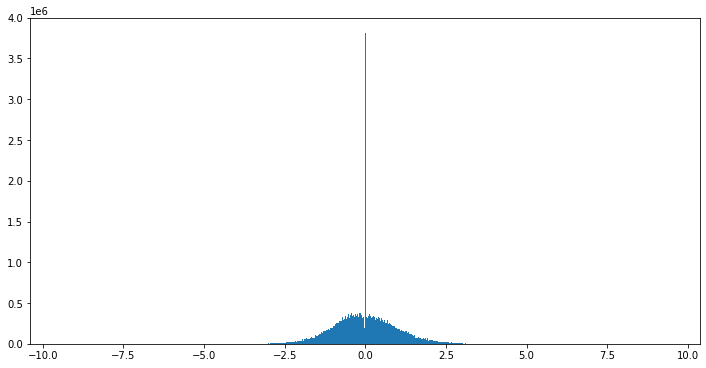

In [5]:
hist1, bin_edges1 = np.histogram(trained_bold, bins=1000)
hist2, bin_edges2 = np.histogram(raw_bold, bins=1000)

plt.figure(figsize=(12, 6))
plt.title('trained bold')
plt.bar(bin_edges1[:-1], hist1, width = bin_edges1[1] - bin_edges1[0])
plt.show()
plt.figure(figsize=(12, 6))
plt.title('raw bold')
plt.bar(bin_edges2[:-1], hist2, width = bin_edges2[1] - bin_edges2[0])
plt.show()


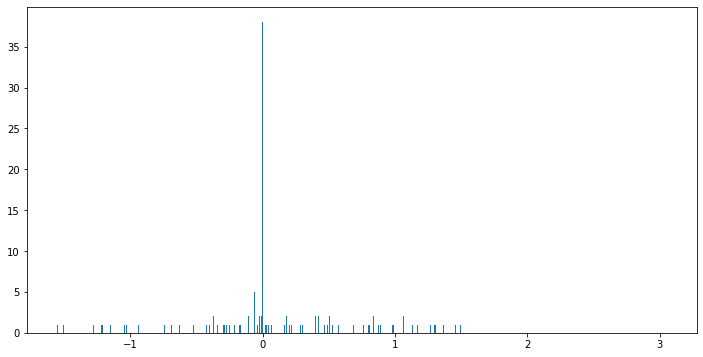

In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.signal import convolve
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.nn import ConstantPad1d


def generate_fmri_data(t, onsets, durations):
    # HRF 함수를 정의합니다.
    def hrf(t):
        # Gamma pdf for the peak
        peak_values = gamma.pdf(t, 6)
        # Gamma pdf for the undershoot
        undershoot_values = gamma.pdf(t, 12)
        # Combine them
        values = peak_values - 0.35 * undershoot_values
        # Scale max to random value between 0.01 and 0.1
        random_value = np.random.uniform(0.2, 0.6)
        return values / np.max(values) *random_value

    def block_function(time, onsets, durations):
        block = np.zeros_like(time)
        block_duration = np.zeros_like(durations)
        interval = time[1] - time[0]
        for index, duration in enumerate(durations):
            block_duration[index] = int(duration/interval)
        for index, loc in enumerate(onsets):
            start = int(loc/interval)
            block[start:start+block_duration[index]] = 1
        return block
    
    hrf_signal = hrf(t)
    block_signal = block_function(t, onsets, durations)
    synthetic_fMRI_signal = convolve(hrf_signal, block_signal, mode='full')[:len(t)]
    noise_std = np.random.uniform(0.4, 0.8)
    thermal_noise = np.random.normal(0, noise_std, synthetic_fMRI_signal.shape)
    thermal_fmri_data = synthetic_fMRI_signal + thermal_noise

    resp_rate = 15
    sampling_rate = 0.5
    duration = 90 / sampling_rate
    resp_t = np.linspace(3, duration, 90)
    resp_frequency = resp_rate / 60
    resp_noise = np.sin(2 * np.pi * resp_frequency * resp_t)
    scaling_factor = 0.05
    res_ther_fmri_data = thermal_fmri_data + resp_noise * scaling_factor

    heart_rate = 60
    sampling_rate = 0.5
    duration = 90 / sampling_rate
    cardiac_t = np.linspace(3, duration, 90)
    cardiac_frequency = heart_rate / 60
    cardiac_noise = np.sin(2 * np.pi * cardiac_frequency * cardiac_t)
    scaling_factor = 0.1
    car_res_ther_fmri_data = res_ther_fmri_data + scaling_factor * cardiac_noise

    return car_res_ther_fmri_data, synthetic_fMRI_signal

num_datasets = 100000
all_datasets = []
time = np.linspace(3, 270, 90)

durations = [60, 60]
    


for i in range(num_datasets):
    random_onset_A = np.random.randint(3, 100)
    random_onset_B = np.random.randint(140,230)
    onsets = [random_onset_A, random_onset_B]
    fmri_data, label = generate_fmri_data(time, onsets, durations)
    all_datasets.append((fmri_data, label))



fmri_sets = all_datasets[:][0]

import numpy as np
import matplotlib.pyplot as plt

hist3, bin_edges3 = np.histogram(fmri_sets, bins=1000)

plt.figure(figsize=(12, 6))
plt.bar(bin_edges3[:-1], hist3, width = bin_edges3[1] - bin_edges3[0])
plt.show()




[ 0.89085551  0.74040161 -0.83677109  1.25548543 -1.124621    0.49268631
  0.0928349  -0.74891127 -0.45893956  0.50377181  1.00222287 -0.20720646
  0.49618778  0.06617811  0.24058532 -0.62065608 -0.60581705 -0.51902609
 -1.31004353  0.54436545 -0.65685185 -0.36172705 -1.27674928 -0.19486635
 -0.13420687  0.76665257 -0.04600948  0.23188077  0.71141146  0.58798172
 -0.25828037  0.58550161  0.83753447 -0.14340609 -1.03659331 -0.88181387
  0.67516089 -0.45623006  0.45835208 -0.7210157   1.3856796   0.22050899
 -0.13928823  0.65691299 -0.10229817  1.29332412  1.00583695  0.48269798
 -0.20372733  0.18507997  0.35690442 -0.16118284  1.34864925 -0.49290573
  0.07676756  0.15975672  1.11221003  0.27802737  1.2851455   0.58577818
  0.82838958  0.84121508  0.07730287  0.58624073  0.52517741 -0.15299176
  0.56088277  0.83490721  0.4279437   0.16719765  0.50721891  0.30967695
 -0.18033669  1.90765426 -0.48107214 -0.52598177 -1.22785035  0.26943258
  0.51509041  0.29007004  0.63999232  0.0655223   0

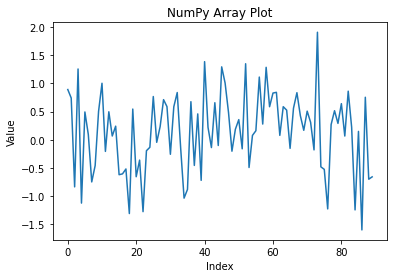

In [12]:
print(all_datasets[0][0])
print(type(all_datasets[0][0]))

import numpy as np
import matplotlib.pyplot as plt

# NumPy 배열 생성
data =all_datasets[0][0]

# 플롯 생성
plt.plot(data)
plt.title('NumPy Array Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
